# Using datasketch to find related sets in large corpora

Computing the exact value for Jaccard similarity or containment for all pairs of sets in the corpus can be an expensive task. Let us consider for instance a corpus composed of 10k tables. Selected a query table and a column out of it, represented as a set of cells, we want to retrieve all tables in the corpus that are joinable with the query table on that column.

In [1]:
import lzma
import pandas as pd
import pickle as pkl

In [2]:
tables = pkl.load(lzma.LZMAFile("datasets/joinable_tables/joinable_tables.pkl", "rb"))
id_mapping = {tables[i]["_id"]: i for i in range(0, len(tables))}  # map table ids to their indices inside the table list
len(tables)

10000

In [3]:
print(tables[0]["_id"])
print(tables[0]["context"])
pd.DataFrame(tables[0]["content"], columns=tables[0]["headers"])

16478687-3_0
List of cities in the Far East by population | Largest urban areas ranked by 2010 projected population | 


,city,sources of pop. / area,population
0,Jakarta,F / B,"22,000,000"
1,Seoul – Incheon,C / B,"19,910,000"
2,Beijing,C / B,"13,955,000"
3,Dongguan,F / B,"10,525,00"
4,Hangzhou,E / B,"5,305,000"
5,Chengdu,E / B,"4,785,000"
6,Singapore,D / B,"4,635,000"
7,Nanjing,E / B,"3,550,000"
8,Dalian,E / B,"3,255,000"
9,Changchun,E / B,"3,170,000"


In [4]:
gt = pd.read_csv("datasets/joinable_tables/joinable_tables.csv")
gt

,query_table,join_table,join_column,query_set_size,join_set_size,joinability,processed,jsim
0,16478687-3_0,16478687-3_1,city,20,27,15,False,0.468750
1,16478687-3_0,16478687-3_2,city,20,49,11,False,0.189655
2,16478687-3_0,16478687-3_3,city,20,39,12,False,0.255319
3,21333468-2_0,21333468-2_1,year,27,34,16,False,0.355556
4,21333468-2_0,21333468-2_2,year,27,29,10,False,0.217391
...,...,...,...,...,...,...,...,...
8413,32426909-9_0,32426909-9_7,player,19,20,11,False,0.392857
8414,32426909-9_0,32426909-9_8,player,19,12,8,True,0.347826
8415,2810483-6_0,2810483-6_1,domestic league,25,26,9,False,0.214286
8416,2810483-6_0,2810483-6_2,domestic league,25,37,14,False,0.291667


datasketch provides probabilistic data structures that can process and search very large amount of data super fast, with little loss of accuracy.

https://ekzhu.com/datasketch/

In [5]:
import datasketch

## MinHash

datasketch.MinHash can be used to estimate the Jaccard similarity (resemblance) between sets of arbitrary sizes in linear time using a small and fixed memory space.

https://ekzhu.com/datasketch/minhash.html

In [6]:
from datasketch import MinHash

Let us consider two sets of values (e.g., two tokenized sentences).

In [7]:
data1 = ['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for', 'estimating', 'the', 'similarity', 'between', 'datasets']
data2 = ['minhash', 'is', 'a', 'probability', 'data', 'structure', 'for', 'estimating', 'the', 'similarity', 'between', 'documents']

We can estimate their Jaccard similarity through MinHash.

In [8]:
m1 = MinHash()  # by default 128 permutations, but the number can be adjusted, e.g., by setting num_perm=256
for d in data1:
    m1.update(d.encode('utf8'))
m1.hashvalues

array([ 297616339,  279951299,  113505080,  311917730,    1735256,
        278730948,  249258812,  306660385,  386953741,  423518424,
        120511132,  607298570,  490287863,  115094987,  290874010,
         58384851,   82568189,  483072302,  312640790,   86174351,
        198731659,  788039411,   54507159,  828911042,   93863906,
         16071831,  260431759,  316407020,  261463262, 1524825895,
        648376383,  206326676,  176707072,   18714679,  478567185,
        180270267,   89979232,  111646838,  240537181,  342142234,
        620096571, 1407834531,  330961037,  663383944, 1105899070,
        181581527,  132285593,  375422674, 1436377075,  484486034,
        252946215,   87331021,  374968398,  968098446,   72863372,
        484842735,  179471924,  672911886,   14648640,  656664915,
        417888415,  271335895,   10055390,   48164330,  430379235,
        622471011,  822143071,  365346353,  210165943,  633147285,
        415249929,  133327723,  258658760,  272079305,  134604

In [9]:
m2 = MinHash()
for d in data2:
    m2.update(d.encode('utf8'))
m2.hashvalues

array([   3749336,  339931219,  113505080,  311917730,    1735256,
        278730948,  249258812,  306660385,  386953741,  423518424,
        236032842,  607298570,  490287863,  115094987,  290874010,
         58384851,   91673879,   59969429,  312640790,  143955678,
        198731659,  261202638,   54507159,  125434160,   93863906,
         16071831,  260431759,  316407020,  261463262, 1414798772,
       1004656905,  206326676,  176707072,  490982219,  296255275,
        180270267,   89979232,  111646838,  240537181,  342142234,
        620096571,  885551337,  108622637,  663383944,  205778805,
         73027438,  132285593,  375422674, 1436377075,  484486034,
        252946215,   87331021,  542874901,  979802008,   72863372,
          5334374,  179471924,  672911886,   14648640,  656664915,
        185261334,  707014827,   10055390,   48164330,  430379235,
        622471011,  822143071,  365346353,  210165943,  658287422,
        415249929,  133327723,   47467434,   65465220,  205526

In [10]:
m1.jaccard(m2)

0.7109375

\[For students\] Let us check the exact value for the Jaccard similarity computed between the two sets of values.

In [11]:
s1 = set(data1)
s2 = set(data2)
actual_jaccard = float(len(s1.intersection(s2))) / float(len(s1.union(s2)))
actual_jaccard

0.7142857142857143

But always keep in mind the shortcomings of Jaccard similarity...

In [12]:
data1 = ['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for', 'estimating', 'the', 'similarity', 'between', 'datasets']
data2 = ['similarity', 'between', 'datasets']

m1, m2 = MinHash(), MinHash()
for d in data1:
    m1.update(d.encode('utf8'))
for d in data2:
    m2.update(d.encode('utf8'))
m1.jaccard(m2)

0.28125

## MinHash LSH

\[For students\] Suppose you have a very large collection of sets. Given a query, which is also a set, you want to find sets in your collection that have Jaccard similarities above certain threshold, and you want to do it with many other queries. To do this efficiently, you can create a MinHash for every set, and when a query comes, you compute the Jaccard similarities between the query MinHash and all the MinHash of your collection, and return the sets that satisfy your threshold. 

In particular, let us consider:
- table "35424124-1_0" as the query table
- and its first column as the query column
- different thresholds too, e.g., 0.7 and 0.5

In [17]:
q_table_id = "35424124-1_0"
q_table_index = id_mapping[q_table_id]
print(tables[q_table_index]["context"])
pd.DataFrame(tables[q_table_index]["content"], columns=tables[q_table_index]["headers"]).head()

List of India Davis Cup team representatives | Players | 


,player,w-l ( singles )
0,Zeeshan Ali,1–8
1,Akhtar Ali,5–2
2,Anand Amritraj,11–17
3,E.V. Bobb,1–3
4,Dilip Bose,1–2


In [18]:
%%time
minhash_list = list()
for table_id in range(0, len(tables)):  # for each table
    if tables[table_id]["_id"] != q_table_id:
        for col_id in range(0, len(tables[table_id]["headers"])):  # for each column of the table
            col_set = {row[col_id] for row in tables[table_id]["content"]}
            m = MinHash()
            for val in list(col_set):
                m.update(val.encode('utf8'))
            minhash_list.append((tables[table_id]["_id"] + "_" + str(col_id), m))

CPU times: user 5.52 s, sys: 64.8 ms, total: 5.58 s
Wall time: 5.6 s


In [20]:
%%time
q_col_id = 0
q_col_set = {row[q_col_id] for row in tables[q_table_index]["content"]}
qm = MinHash()
for val in list(q_col_set):
    qm.update(val.encode('utf8'))
join_cols = list()
for col in minhash_list:
    if qm.jaccard(col[1]) >= 0.5:
        join_cols.append(col[0])
join_cols

CPU times: user 25.4 ms, sys: 1.11 ms, total: 26.5 ms
Wall time: 25.6 ms


['35424124-1_1_0', '35424124-1_4_0']

The said approach is still an O(n) algorithm, meaning the query cost increases linearly with respect to the number of sets. A popular alternative is to use Locality Sensitive Hashing (LSH) index. LSH can be used with MinHash to achieve sub-linear query cost - that is a huge improvement.

In [21]:
from datasketch import MinHashLSH

In [22]:
set1 = set(['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for', 'estimating', 'the', 'similarity', 'between', 'datasets'])
set2 = set(['minhash', 'is', 'a', 'probability', 'data', 'structure', 'for', 'estimating', 'the', 'similarity', 'between', 'documents'])
set3 = set(['similarity', 'between', 'documents'])

In [23]:
m1 = MinHash(num_perm=128)
m2 = MinHash(num_perm=128)
m3 = MinHash(num_perm=128)
for d in set1:
    m1.update(d.encode('utf8'))
for d in set2:
    m2.update(d.encode('utf8'))
for d in set3:
    m3.update(d.encode('utf8'))

In [24]:
lsh = MinHashLSH(threshold=0.5, num_perm=128)
lsh.insert("m2", m2)
lsh.insert("m3", m3)
lsh.query(m1)

['m2']

Define the query table and column and compute its MinHash.

In [25]:
q_table_id = "35424124-1_0"
q_table_index = id_mapping[q_table_id]
q_col_id = 0
q_col_set = {row[q_col_id] for row in tables[q_table_index]["content"]}
qm = MinHash(num_perm=128)
for val in list(q_col_set):
    qm.update(val.encode('utf8'))

Let us reply the previous search for joinable columns using MinHash LSH. First, insert into the LSH index the MinHash of all table columns in the corpus.

In [26]:
lsh = MinHashLSH(threshold=0.5, num_perm=128)
for table_index in range(0, len(tables)):  # for each table
    if tables[table_index]["_id"] != q_table_id:
        for col_id in range(0, len(tables[table_index]["headers"])):  # for each column of the table
            col_set = {row[col_id] for row in tables[table_index]["content"]}
            m = MinHash(num_perm=128)
            for val in list(col_set):
                m.update(val.encode('utf8'))
            lsh.insert(tables[table_index]["_id"] + "_" + str(col_id), m)

Then, obtain the ones with a Jaccard similarity above the defined threshold.

In [35]:
%%time 
## compare the time with the previous approach
lsh.query(qm)

CPU times: user 181 µs, sys: 204 µs, total: 385 µs
Wall time: 301 µs


['35424124-1_4_0', '35424124-1_1_0']

In [36]:
print(lsh.b, lsh.r)

25 5


\[For students\] datasketch supports table querying scenario. Nevertheless, finding all pairs of sets whose similarity overcomes the defined threshold is useful in many cases. Therefore, try to implement MinHash LSH Banding to obtain all pairs of similar sets in the corpus.

In [37]:
# Compute MinHash for each table column
minhash_list = list()
for table_id in range(0, len(tables)):  # for each table
    for col_id in range(0, len(tables[table_id]["headers"])):  # for each column of the table
        col_set = {row[col_id] for row in tables[table_id]["content"]}
        m = MinHash()
        for val in list(col_set):
            m.update(val.encode('utf8'))
        minhash_list.append((tables[table_id]["_id"] + "_" + str(col_id), m))

In [38]:
# Perform MinHash LSH Banding
minhash_size = 128
num_bands = 16
num_rows = int(minhash_size / num_bands)  # number of rows in each band
pins = [i for i in range(0, minhash_size, num_rows)]  # bit intervals to decompose the minhash into bands
pins.append(minhash_size)  # include the last bit to denote the last band
buckets = [dict() for _ in range(0, num_bands)]  # list of dictionaries to store the buckets for each band
for item in minhash_list:
    for i in range(0, num_bands):  # decompose the minhash into bands
        hash_value = hash("".join([str(h) for h in item[1].hashvalues.tolist()[pins[i]:pins[i + 1]]]))  # value for the current band
        if hash_value not in buckets[i].keys():  # if the value is not present in buckets, create a new bucket for that band
            buckets[i][hash_value] = [item[0]]
        else:  # otherwise, insert the column into the existing bucket
            buckets[i][hash_value].append(item[0])
clusters = list()  # list of all clusters determined by the generated buckets
for i in range(0, num_bands):  # for each band, read its buckets
    for bucket in buckets[i].items():
        if len(bucket[1]) > 1:  # if the bucket contains more than one element (i.e., generates pairs of similar sets)
            cluster = dict()  # initialize the corresponding cluster as a dictionary
            cluster["_id"] = str(bucket[0]) + "-" + str(i)  # discriminate among same bucket identifiers in different bands
            cluster["sets"] = bucket[1]  # list of sets
            clusters.append(cluster)

In [39]:
from itertools import combinations

In [40]:
# Generate the pairs of similar sets
set_pairs = set()  # set to store the distinct set pairs
for cluster in clusters:  # for each cluster
    cluster_set_pairs = list(combinations(sorted(cluster["sets"]), 2))  # compute the set pairs
    for set_pair in cluster_set_pairs:  # add each table pair to the set pairs
        set_pairs.add(set_pair)
len(set_pairs)

2548

In [41]:
list(set_pairs)[:10]

[('9598047-1_2_0', '9598047-1_4_0'),
 ('170982-1_1_0', '170982-1_6_0'),
 ('19498116-2_0_0', '19498116-2_5_0'),
 ('1825085-3_1_0', '1825085-3_3_0'),
 ('33116-1_6_0', '5492852-1_3_0'),
 ('3551842-1_3_0', '3551842-1_5_0'),
 ('1370270-2_1_0', '1370270-2_5_0'),
 ('24301284-14_5_0', '24301284-14_6_0'),
 ('25360753-1_1_0', '25360753-1_3_0'),
 ('14777223-1_3_0', '14777223-1_5_0')]

# MinHash LSH Forest

MinHash LSH is useful for threshold queries. However, top-k queries are often more useful in some cases. LSH Forest is a general LSH data structure that makes top-k query possible for many different types of LSH indexes, including MinHash LSH. MinHash LSH Forest returns therefore the top-k matching sets that have the approximately highest Jaccard similarity with the query set.

In [42]:
q_table_id = "23912408-1_0"
q_table_index = id_mapping[q_table_id]
print(tables[q_table_index]["_id"])
print(tables[q_table_index]["context"])
pd.DataFrame(tables[q_table_index]["content"], columns=tables[q_table_index]["headers"])

23912408-1_0
List of Nürburgring fatal accidents | List of fatal accidents involving competitors | 


,competitor,section,course
0,Emil Frankl,,Nordschleife
1,Theodor Weißenberger,Metzgesfeld,Nordschleife
2,Onofre Marimón,Adenau Bridge,Nordschleife
3,Rudi Godin,Pflanzgarten,Nordschleife
4,Peter Collins,Pflanzgarten,Nordschleife
5,Fausto Meyrat,Kesselchen,Nordschleife
6,Alfred Wohlgemuth,,Südschleife/Zielschleife
7,Dickie Dale,Bocksberg,Südschleife/Zielschleife
8,Günter Strasburger,,Südschleife/Zielschleife
9,Herbert Mandel,Müllenbach,Südschleife


In [43]:
gt[gt["query_table"] == q_table_id]

,query_table,join_table,join_column,query_set_size,join_set_size,joinability,processed,jsim
812,23912408-1_0,23912408-1_1,competitor,22,42,18,False,0.391304
813,23912408-1_0,23912408-1_2,competitor,22,42,19,False,0.422222
814,23912408-1_0,23912408-1_3,competitor,22,23,14,False,0.451613
815,23912408-1_0,23912408-1_4,competitor,22,53,17,False,0.293103
816,23912408-1_0,23912408-1_5,competitor,22,41,13,False,0.260000
817,23912408-1_0,23912408-1_6,competitor,22,59,19,True,0.306452


In [45]:
table_index = id_mapping["23912408-1_3"]
pd.DataFrame(tables[table_index]["content"], columns=tables[table_index]["headers"]).head()

,competitor,date,machine,course
0,Marc van de Brandeler,5 Sep 1999,Porsche 993,Nordschleife
1,Corrado Antonello,16 June 1979,Laverda,Nordschleife
2,Josef Hackenberg,25 May 1952,BMW Veritas RS,Nordschleife
3,Rüdiger Schwietring,6 Oct 1973,Honda 750cc,Südschleife
4,Onofre Marimón,31 July 1954,Maserati 250F,Nordschleife


In [47]:
q_col_id = 0
q_col_set = {row[q_col_id] for row in tables[q_table_index]["content"]}
qm = MinHash(num_perm=128)
for val in list(q_col_set):
    qm.update(val.encode('utf8'))
q_col_set

{'Alex Wittwer',
 'Alfred Wohlgemuth',
 'Corrado Antonello',
 'Dickie Dale',
 'Emil Frankl',
 'Erich Bertholdt',
 'Fausto Meyrat',
 'Günter Strasburger',
 'Hans-Ruedi Portmann',
 'Heinz Behrentin',
 'Herbert Mandel',
 'Jorma Nevala',
 'Leo Löwenstein',
 'Manfred König',
 'Oliver Perschke',
 'Onofre Marimón',
 'Peter Collins',
 'Rudi Godin',
 'Rüdiger Schwietring',
 'Stefan Eickelmann',
 'Theodor Weißenberger',
 'Walter Czadek'}

In [48]:
lsh = MinHashLSH(threshold=0.5, num_perm=128)
for table_index in range(0, len(tables)):  # for each table
    if tables[table_index]["_id"] != q_table_id:
        for col_id in range(0, len(tables[table_index]["headers"])):  # for each column of the table
            col_set = {row[col_id] for row in tables[table_index]["content"]}
            m = MinHash(num_perm=128)
            for val in list(col_set):
                m.update(val.encode('utf8'))
            lsh.insert(tables[table_index]["_id"] + "_" + str(col_id), m)

In [49]:
lsh.query(qm)

['23912408-1_2_0']

In [50]:
table_index = id_mapping["23912408-1_2"]
pd.DataFrame(tables[table_index]["content"], columns=tables[table_index]["headers"]).head()

,competitor,no,course
0,Dickie Dale,23,Südschleife/Zielschleife
1,Brian Hetreed,28,Nordschleife
2,Honoré Wagner,32,Nordschleife
3,Klein,40,Nordschleife
4,Ernst Raetz,51,Nordschleife


In [51]:
from datasketch import MinHashLSHForest

In [52]:
forest = MinHashLSHForest(num_perm=128)
for table_index in range(0, len(tables)):  # for each table
    if tables[table_index]["_id"] != q_table_id:
        for col_id in range(0, len(tables[table_index]["headers"])):  # for each column of the table
            col_set = {row[col_id] for row in tables[table_index]["content"]}
            m = MinHash(num_perm=128)
            for val in list(col_set):
                m.update(val.encode('utf8'))
            forest.add(tables[table_index]["_id"] + "_" + str(col_id), m)
forest.index()

In [53]:
forest.query(qm, 5)

['23912408-1_5_0',
 '23912408-1_3_0',
 '23912408-1_1_0',
 '23912408-1_2_0',
 '23912408-1_4_0']

## MinHash LSH Ensemble

LSH Ensemble is a LSH index for containment search: given a query set, it returns sets with containment above a certain threshold.

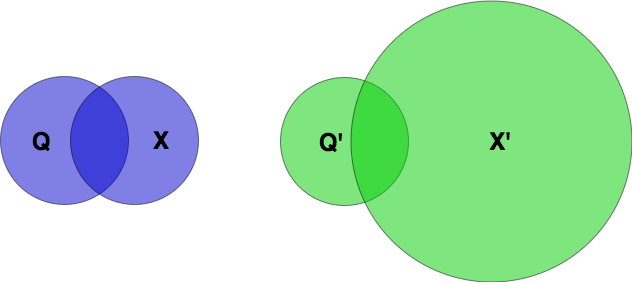

https://ekzhu.com/datasketch/lshensemble.html

In [54]:
from datasketch import MinHashLSHEnsemble

In [55]:
q_table_id = "23912408-1_0"
q_table_index = id_mapping[q_table_id]
q_col_id = 0
q_col_set = {row[q_col_id] for row in tables[q_table_index]["content"]}
qm = MinHash(num_perm=128)
for val in list(q_col_set):
    qm.update(val.encode('utf8'))

In [56]:
lshensemble = MinHashLSHEnsemble(threshold=0.8, num_perm=128, num_part=32)
triples = list()  # an iterable of (key, minhash, size)
for table_index in range(0, len(tables)):  # for each table
    if tables[table_index]["_id"] != q_table_id:
        for col_id in range(0, len(tables[table_index]["headers"])):  # for each column of the table
            col_set = {row[col_id] for row in tables[table_index]["content"]}
            m = MinHash(num_perm=128)
            for val in list(col_set):
                m.update(val.encode('utf8'))
            triples.append((tables[table_index]["_id"] + "_" + str(col_id), m, len(col_set)))
lshensemble.index(triples)

In [57]:
[key for key in lshensemble.query(qm, len(q_col_set))]

['23912408-1_5_0', '23912408-1_1_0', '23912408-1_2_0', '23912408-1_4_0']

## Bonus: Tokenization

In [58]:
gt[gt["query_table"] == q_table_id]

,query_table,join_table,join_column,query_set_size,join_set_size,joinability,processed,jsim
812,23912408-1_0,23912408-1_1,competitor,22,42,18,False,0.391304
813,23912408-1_0,23912408-1_2,competitor,22,42,19,False,0.422222
814,23912408-1_0,23912408-1_3,competitor,22,23,14,False,0.451613
815,23912408-1_0,23912408-1_4,competitor,22,53,17,False,0.293103
816,23912408-1_0,23912408-1_5,competitor,22,41,13,False,0.260000
817,23912408-1_0,23912408-1_6,competitor,22,59,19,True,0.306452


In [60]:
table_index = id_mapping["23912408-1_6"]
pd.DataFrame(tables[table_index]["content"], columns=tables[table_index]["headers"]).head()

,competitor,course,machine
0,Bernhard_Thiel,Nordschleife,Borgward Isabella
1,Klein,Nordschleife,Porsche GT
2,Erwin_Bauer,Nordschleife,Ferrari 250 TR
3,Toni_Babl,Nordschleife,600cc Douglas Sidecar
4,Lutz-Barthel,GP-Strecke,BMW 328


\[For students\] Note that we can tokenize our cell values at different levels.

In [62]:
import re

In [63]:
q_col_id = 0
q_col_set = {token for row in tables[q_table_index]["content"] for token in re.split(" |-|_|'", row[q_col_id])}
qm = MinHash(num_perm=128)
for val in list(q_col_set):
    qm.update(val.encode('utf8'))
q_col_set

{'Alex',
 'Alfred',
 'Antonello',
 'Behrentin',
 'Bertholdt',
 'Collins',
 'Corrado',
 'Czadek',
 'Dale',
 'Dickie',
 'Eickelmann',
 'Emil',
 'Erich',
 'Fausto',
 'Frankl',
 'Godin',
 'Günter',
 'Hans',
 'Heinz',
 'Herbert',
 'Jorma',
 'König',
 'Leo',
 'Löwenstein',
 'Mandel',
 'Manfred',
 'Marimón',
 'Meyrat',
 'Nevala',
 'Oliver',
 'Onofre',
 'Perschke',
 'Peter',
 'Portmann',
 'Rudi',
 'Ruedi',
 'Rüdiger',
 'Schwietring',
 'Stefan',
 'Strasburger',
 'Theodor',
 'Walter',
 'Weißenberger',
 'Wittwer',
 'Wohlgemuth'}

In [68]:
lshensemble = MinHashLSHEnsemble(threshold=0.8, num_perm=128, num_part=32)
triples = list()  # an iterable of (key, minhash, size)
for table_index in range(0, len(tables)):  # for each table
    if tables[table_index]["_id"] != q_table_id:
        for col_id in range(0, len(tables[table_index]["headers"])):  # for each column of the table
            col_set = {token for row in tables[table_index]["content"] for token in re.split(" |-|_|'", row[col_id])}
            m = MinHash(num_perm=128)
            for val in list(col_set):
                m.update(val.encode('utf8'))
            triples.append((tables[table_index]["_id"] + "_" + str(col_id), m, len(col_set)))
lshensemble.index(triples)

In [69]:
[key for key in lshensemble.query(qm, len(q_col_set))]

['23912408-1_5_0', '23912408-1_2_0', '23912408-1_4_0', '23912408-1_6_0']